In [87]:
# Für Imports (:P)
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2
import numpy as np

In [61]:
%matplotlib inline

## Overview of the steps

1. Camera calibration
1. Distortion correction
1. Color/gradient threshold
1. Perspective transform
1. Lane detection
1. Lane curvature calculation
1. Inverse perspective transform
1. Display of detected lane on the original image

## 1. Camera calibration

### 1.a Look at files for camera calibration

In [203]:
# Return the list of calibration files
def calibration_files():
    return list(map(lambda x: 'camera_cal/' + x, os.listdir('./camera_cal')))

In [104]:
for file in calibration_files():
    print(file)

camera_cal/calibration1.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration2.jpg
camera_cal/calibration20.jpg
camera_cal/calibration3.jpg
camera_cal/calibration4.jpg
camera_cal/calibration5.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg


In [105]:
print(len(calibration_files()))

20


We have about 20 images for calliberation

In [202]:
# Given a list of image paths, return the loaded images in RGB
# format as a list
def load_images(images):
    loaded_images = []
    
    for image in images:
        loaded_images.append(mpimg.imread(image))
        
    return loaded_images

In [367]:
# Given a list of images and number of images per row,
# display those images
def show_images(images, n_rows, cmaps=[]):
    n_images = len(images)
    n_cols = math.ceil(1.0 * n_images / n_rows)
    
    f, subplots = plt.subplots(n_rows, n_cols, figsize=(20, 9))
    f.tight_layout()
    subplots = subplots.flatten()
    
    for index, image in enumerate(images):
        try:
            cmap = cmaps[index]
        except IndexError:
            cmap = None
            
        subplots[index].imshow(image, cmap=cmap)

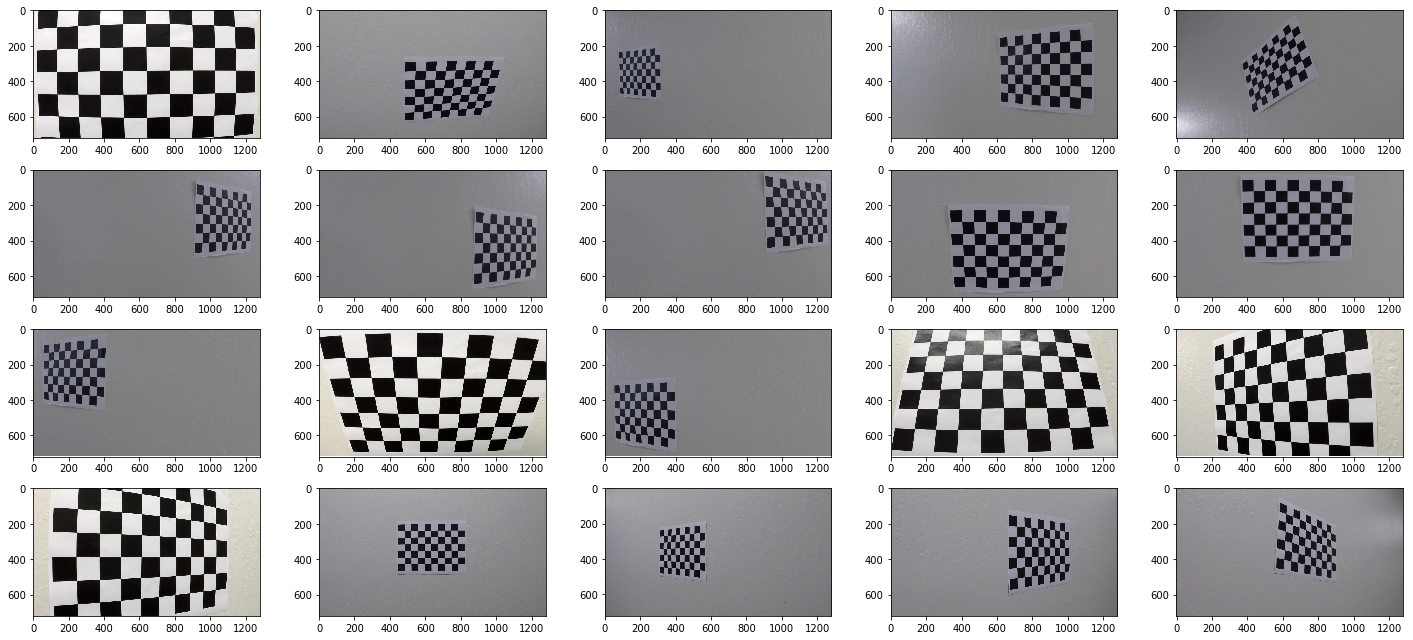

In [106]:
show_images(load_images(calibration_files()), 4)

#### Observation

We can see a bunch of chessboard images from different angles and thus distorted to different extent.

### 1.b Calibrate camera

In [200]:
# Given a list of chessboard images, calculate generate the obj points,
# calculate the imgpoints, and return the distortion parameters
def calibrate_camera(images):
    objpoints = []
    imgpoints = []
    
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        
        if ret:
            objp = np.zeros((9*6, 3), np.float32)
            objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
            
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, images[0].shape[0:2], None, None)
    
    return mtx, dist

## 2. Distortion correction

In [114]:
mtx, dst = calibrate_camera(load_images(calibration_files()))

In [199]:
# Undistort images given an image, and the distortion
# parameters
def undistort_image(image, mtx, dst):
    return cv2.undistort(image, mtx, dst, None, mtx)

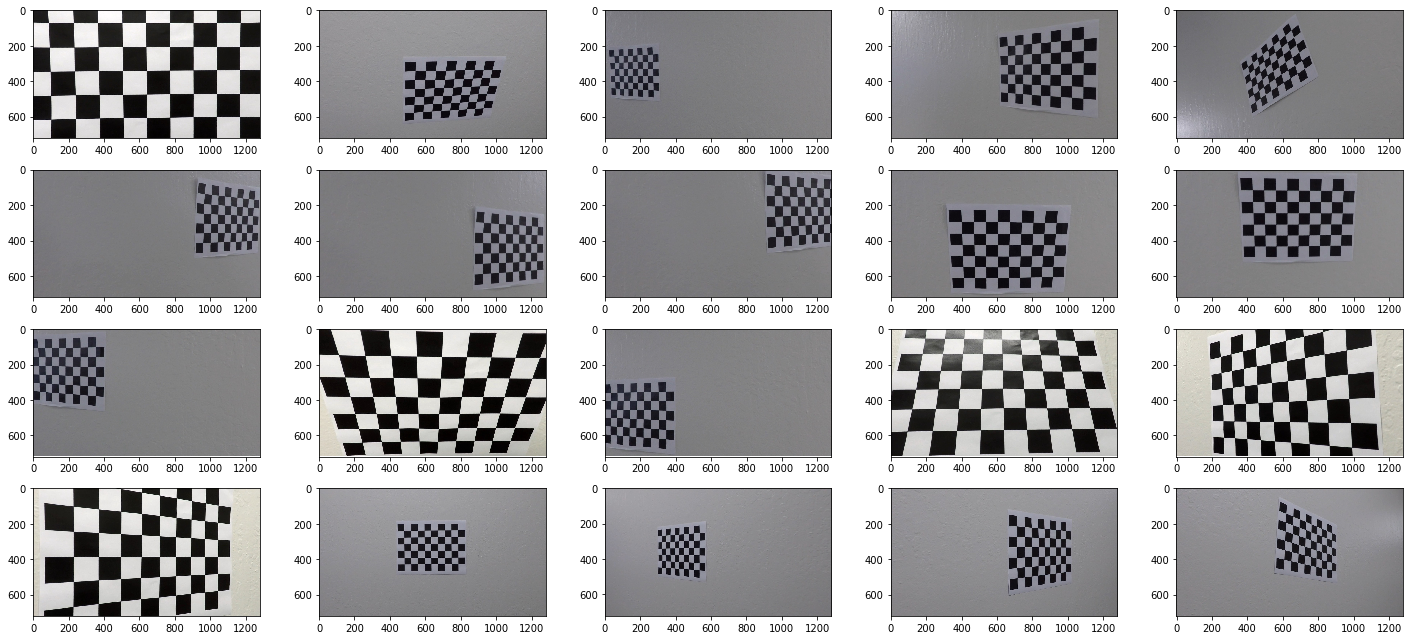

In [124]:
show_images(list(map(lambda x: undistort_image(x, mtx, dst), load_images(calibration_files()))), 4)

#### Observation

Images look pretty undistorted!

## 3. Color/gradient threshold

In [197]:
# Convert an RGB image to grayscale
def grayscale_img(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [198]:
# Display a binary image
def display_binary(img):
    plt.imshow(img, cmap='gray')

### 3.a Sobel gradient

In [196]:
# Apply the x-sobel gradient to the given grayscale
# image
def sobel_x(g_img, thresh=(20, 100)):
    sobel = cv2.Sobel(g_img, cv2.CV_64F, 1, 0)
    abs_sobel = np.abs(sobel)
    
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_sobel

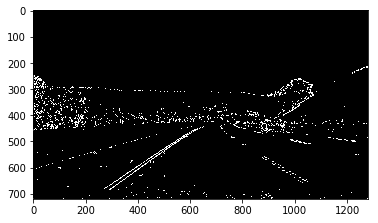

In [190]:
display_binary(sobel_x(grayscale_img(load_images(['./test_images/test3.jpg'])[0]), thresh=(20,100)))

#### Observation

Looks pretty decent. Both the lanes have been detected to the extent possible.

### 3.b Color thresholding

In [194]:
# Convert an RGB image to HLS
def hls_img(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [195]:
# Apply color threshold on the S channel to an HLS
# image
def color_threshold(hls, thresh=(170,255)):
    s_channel = hls[:,:,2]
    binary_img = np.zeros_like(s_channel)
    
    binary_img[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_img

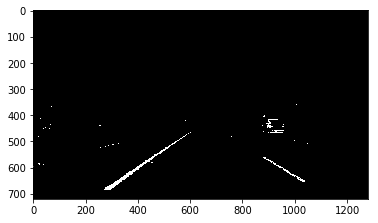

In [188]:
display_binary(color_threshold(hls_img(load_images(['./test_images/test3.jpg'])[0]), thresh=(140,255)))

#### Observation

The left lane is crisply detected. The right lane too, to a good extent.

### 3.c Combined thresholding

In [193]:
# Given a variable number of binary images,
# OR them into a combined image
def combine_thresholds(*thresholds):
    # Initialize a binary image
    binary_img = np.zeros_like(thresholds[0])

    for img in thresholds:
        binary_img = binary_img | img
        
    return binary_img

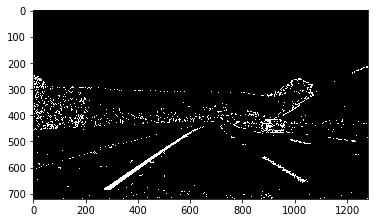

In [192]:
def test_thresholding():
    img = load_images(['./test_images/test3.jpg'])[0]
    g_img = grayscale_img(img)
    hls = hls_img(img)
    
    thresholds = [
        sobel_x(g_img, thresh=(20, 100)),
        color_threshold(hls, thresh=(140, 255))
    ]
    
    final_img = combine_thresholds(*thresholds)
    
    display_binary(final_img)

test_thresholding()

#### Observation

Combining both the thresholding yeilds an image with prominent lanes.

## 4. Perspective transform

### 4.a Find out perspective points

In [304]:
# Given an image, overlay polygon described by points
# on top of it
def draw_polygon(img, points):
    copy = img.copy()
    cv2.polylines(copy, [points], True, (255, 0, 0), thickness=3)
    
    return copy

In [352]:
# Before points for the perspective transform
def perspective_before_points():
    return {
        'bottom-left': (200, 720),
        'bottom-right': (1110, 720),
        'top-left': (560, 470),
        'top-right': (720, 470)
    }

In [300]:
# After points for the perspective transform
def perspective_after_points():
    return {
        'bottom-left': (350, 720),
        'bottom-right': (980, 720),
        'top-left': (350, 0),
        'top-right': (980, 0)
    }

In [305]:
# Given the dictionary of points, convert them to a 
# integer numpy array
def points_to_array(points):
    return np.int32([
        points['top-left'],
        points['top-right'],
        points['bottom-right'],
        points['bottom-left']
    ])

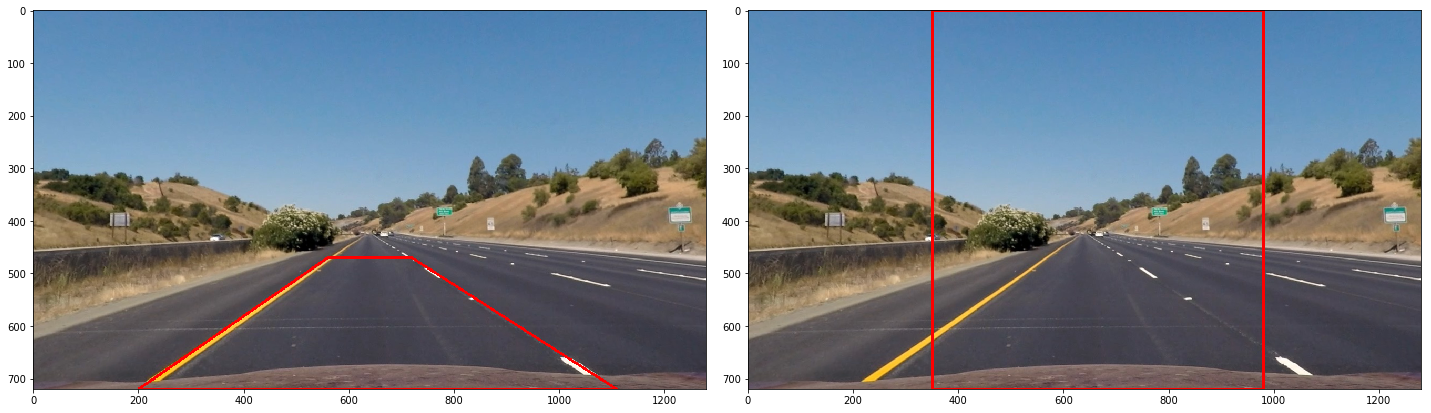

In [353]:
# Test out the points selected above on an image
def test_perspective_points():
    before_points = points_to_array(perspective_before_points())
    after_points = points_to_array(perspective_after_points())
    
    img = load_images(['./test_images/straight_lines1.jpg'])[0]
    img = undistort_image(img, mtx, dst)
    
    img_before = draw_polygon(img, before_points)
    img_after = draw_polygon(img, after_points)
    
    show_images([img_before, img_after], 1)
    
test_perspective_points()

#### Observation

Using the visualization above, it was easy to fiddle with the numbers till I got a satisfactory looking polygon.

### 4.b Use perspective transform on an image

In [311]:
# Given the before and after points, come up with the perspective
# transform matrix "M"
def perspective_transform(before_points, after_points):
    # Convert dictionaries to np arrays
    before_points_np = np.float32(points_to_array(before_points))
    after_points_np = np.float32(points_to_array(after_points))
    
    return cv2.getPerspectiveTransform(before_points_np, after_points_np)

In [308]:
# Given an image and the perspective transform matrix, get the warped
# image
def warp_perspective(img, M):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

In [309]:
# A helper function to get M
def std_perspective_transform():
    before_points = perspective_before_points()
    after_points = perspective_after_points()
    
    return perspective_transform(before_points, after_points)

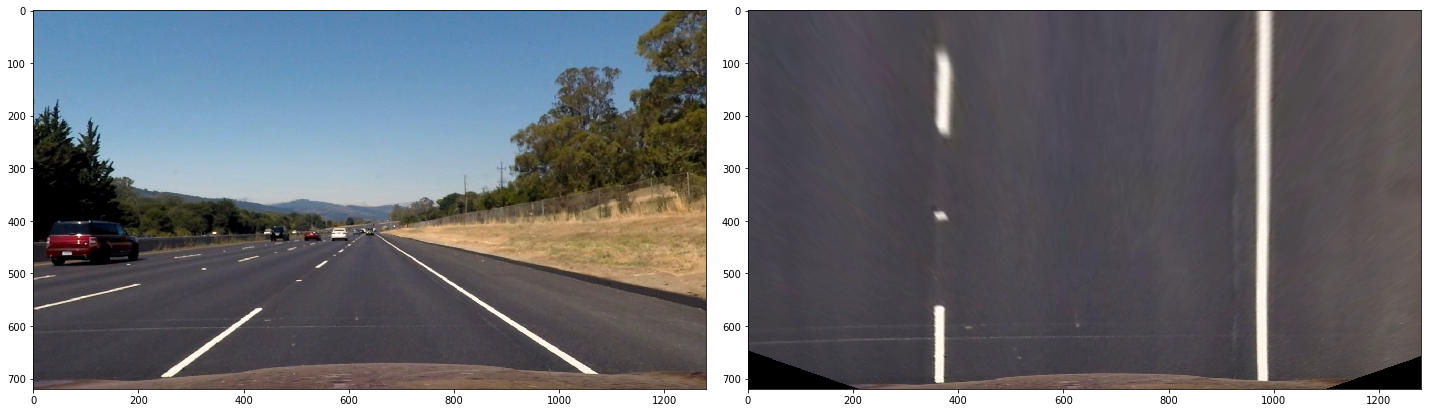

In [358]:
# Check how things are looking
def test_perspective_transform():
    img = load_images(['./test_images/straight_lines2.jpg'])[0]
    img = undistort_image(img, mtx, dst)
    
    M = std_perspective_transform()
    warped_img = warp_perspective(img, M)
    
    show_images([img, warped_img], 1)
    
test_perspective_transform()

#### Observation

The transform looks okay. I have to keep in mind that it's not being applied to the undistorted image above (though in the final pipeline, it will be).

## 5. Lane detection

Let's get down the detecting the two lanes as lines.

### 5.a Get an image ready for lane detection

In [363]:
# Return an image that's ready for lane detection
def image_for_lane_detection(img, mtx, dst):
    # Undistort
    img = undistort_image(img, mtx, dst)
    
    # Grayscale and hls
    g_img = grayscale_img(img)
    hls = hls_img(img)
    
    # Thresholding
    thresholds = [
        sobel_x(g_img, thresh=(20, 100)),
        color_threshold(hls, thresh=(140, 255))
    ]
    thresholded_img = combine_thresholds(*thresholds)
    
    # Perspective transform
    M = std_perspective_transform()
    
    return warp_perspective(thresholded_img, M)

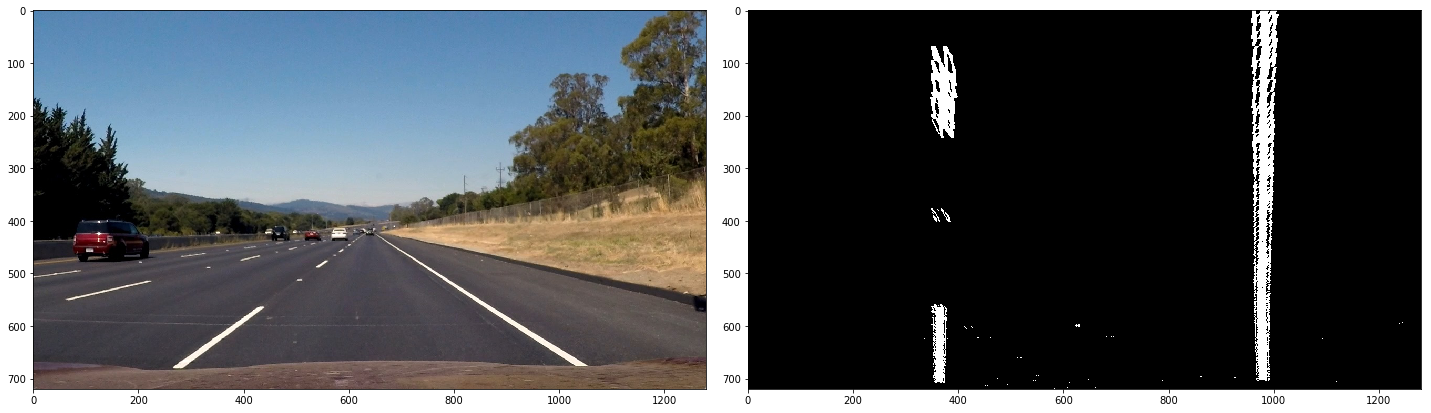

In [371]:
def test_image_for_lane_detection():
    img = load_images(['./test_images/straight_lines2.jpg'])[0]
    
    final_img = image_for_lane_detection(img, mtx, dst)
    
    show_images([img, final_img], 1, cmaps=[None, 'gray'])
    
test_image_for_lane_detection()

#### Observation

The image on the right looks good. We can start lane detection on it.

### 3.b Fit polynomial for both the lanes

In [373]:
def lanes_starting_image():
    img = load_images(['./test_images/straight_lines2.jpg'])[0]
    return image_for_lane_detection(img, mtx, dst)

In [375]:
def histogram(binary_img):
    return np.sum(binary_img[binary_img.shape[0]//2:,:], axis=0)

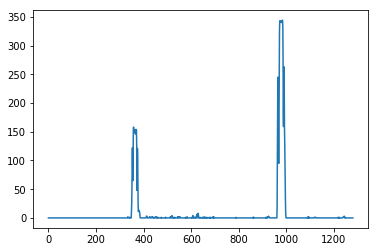

In [378]:
plt.plot(histogram(lanes_starting_image()))

#### Observation

We see two prominent spikes indicating the lanes

In [379]:
# Get the left and right lane bases
def get_lane_bases(histogram_img):
    midpoint = histogram_img.shape[0]//2
    left_base = np.argmax(histogram_img[:midpoint])
    right_base = np.argmax(histogram_img[midpoint:]) + midpoint
    
    return left_base, right_base

In [380]:
# Get all non-zero pixels
def get_non_zero_pixels(img):
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[0])
    nonzeroy = np.array(nonzero[1])
    
    return nonzerox, nonzeroy

In [425]:
# Get lane boxes for just one lane line at a time
def lane_boxes(img, lane_base, window, nonzerox, nonzeroy):
    # Height of the image
    height = img.shape[0]
    
    # No. of vertical windows
    n_windows = 9

    # Min. no of pixels inside a window
    minpix = 50
    
    # Width of a window = +- margin
    margin = 100
    
    # Lane indices detected
    lane_indices = []
    
    # Height of a window
    window_height = np.int(height/n_windows)
    
    # Loop through all the windows
    current_base = lane_base
    lane_indices = []
    for window in range(n_windows):
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height
        win_x_low = current_base - margin
        win_x_high = current_base + margin
        
        good_filter_y = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
        good_filter_x = (nonzerox >= win_x_low) & (nonzerox < win_x_high)
        good_indices = (good_filter_y & good_filter_x).nonzero()[0]
        
        lane_indices.append(good_indices)
        
        if len(lane_indices) > minpix:
            current_base = np.int(np.mean(nonzerox[good_indices]))
            
    lane_indices = np.concatenate(lane_indices)
    lane_x = nonzerox[lane_indices]
    lane_y = nonzeroy[lane_indices]
    
    return np.polyfit(lane_x, lane_y, 2)

In [421]:
def fit_lane_polynomial(img):
    histogram_img = histogram(img)
    left_base, right_base = get_lane_bases(histogram_img)
    nonzerox, nonzeroy = get_non_zero_pixels(img)
    print(nonzerox, nonzeroy)
    
#     left_lane = lane_boxes(img, left_base, 100, nonzerox, nonzeroy)
    right_lane = lane_boxes(img, right_base, 100, nonzerox, nonzeroy)
    
#     return left_lane, right_lane

In [426]:
def test_lane_fitting():
    img = lanes_starting_image()
    
    fit_lane_polynomial(img)
    print(left_lane)
    
test_lane_fitting()

(720, 1280)
[  0   0   0 ..., 718 719 719] [959 960 961 ..., 608 582 608]


TypeError: expected non-empty vector for x